# 📘 Tarea: Clasificación con SVM en un contexto de Clases No Balanceadas

**Nivel:** Maestría  
**Duración estimada:** 2-3 horas  
**Herramientas:** Python, Scikit-Learn, imbalanced-learn, Matplotlib, Google Colab  
**Temas clave:**  
- Clasificación con SVM  
- Clases no balanceadas  
- Validación cruzada estratificada  
- Métricas adaptadas a desbalance  
- SMOTE y otras técnicas de remuestreo


## 🧾 Objetivos de aprendizaje

Al finalizar esta tarea, el estudiante será capaz de:

- Identificar los efectos del desbalance de clases en modelos clasificadores.
- Implementar una SVM en un escenario multiclase o binario con fuerte desbalance.
- Evaluar el rendimiento del modelo usando métricas robustas como recall, F1, y G-mean.
- Aplicar técnicas como SMOTE y comparar su impacto.
- Utilizar `StratifiedKFold` para asegurar la adecuada evaluación del modelo.


## 📁 Entregables

- Google Colab Notebook con:
  - Código bien comentado
  - Gráficas solicitadas
  - Conclusiones reflexivas al final
- Exportación del notebook a PDF


# Librerias


In [5]:
def separador():
    print("\n" + "=" * 170 + "\n")
def header(Titulo):
  por=((170-len(Titulo))//10)
  a=int(1.2*por)
  print("."*a+"·"*a+"~"*a+"≈"*a+"≋"
  *int(por*.2),Titulo,"≋"*int(por*.2)
  +"≈"*a+"~"*a+"·"*a+"."*a,"\n\n")
from sklearn.datasets import load_breast_cancer #se importa el dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler#escalador para aplicar en el pipeline de la svm
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline #pipeline especial
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict #validación cruzada estratificada
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix #métricas
from imblearn.over_sampling import SMOTE

# 1. **Carga y exploración del dataset**
   - Utiliza el dataset `breast_cancer` o `wine` de Scikit-Learn.
   - Verifica la distribución de clases.
   - Visualiza con un gráfico la distribución y las principales características.

...............···············~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ 1. Carga y exploración del dataset ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~···············............... 


.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these feat

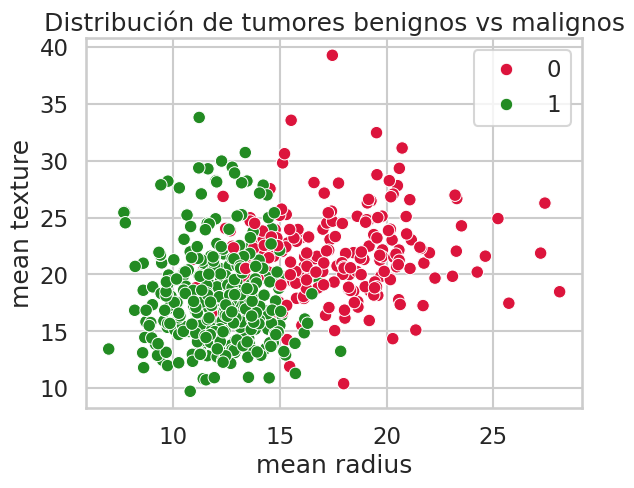



Distribución de todas las columnas


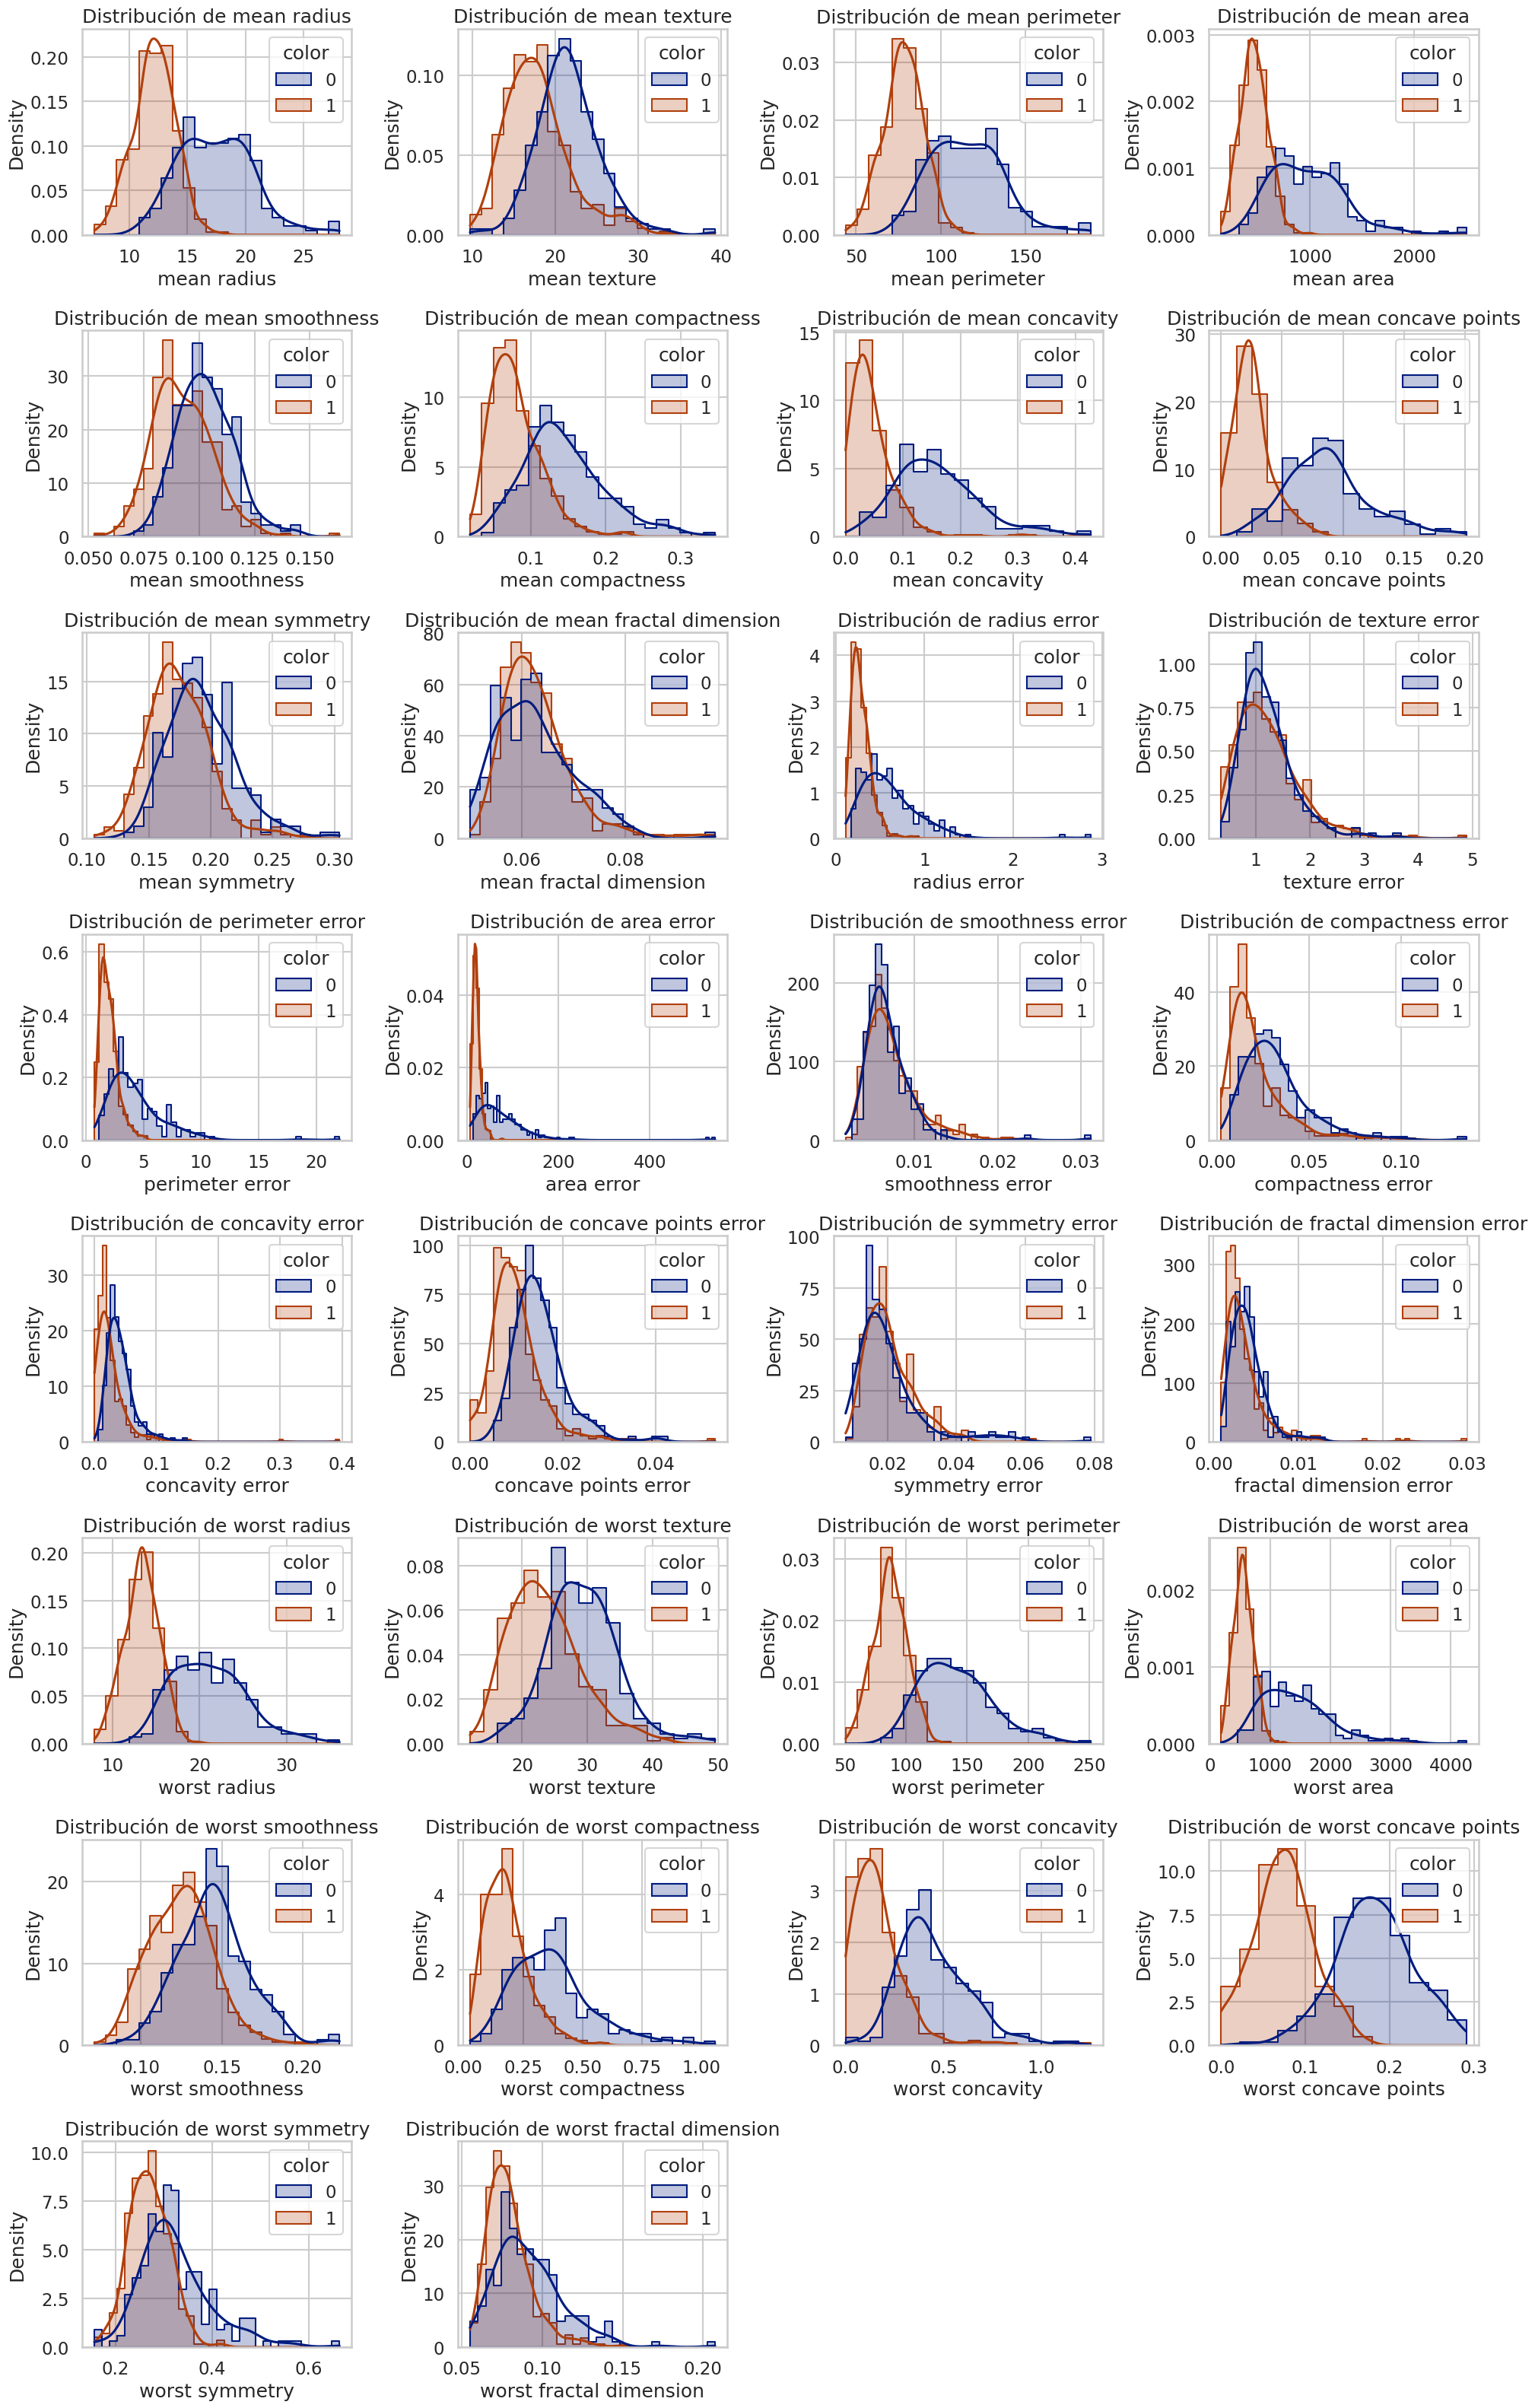

In [6]:
header('1. Carga y exploración del dataset')
breast_cancer_data = load_breast_cancer()  #variable para el dataset

#se definen el target y data
X = breast_cancer_data.data
y = breast_cancer_data.target

#principales caracteristicas:
print(breast_cancer_data.DESCR);separador()
#se verifica la distribución de las clases
print("\nDistribución de clases:")
unique, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Clase {cls} : {count} muestras ({count/len(y)*100:.2f}%)")
#proporcion del desbalance:
print(f"\nProporción del desbalance: {counts[0]/counts[1]:.2f}")
#scatterplot para mejor visualización
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=['crimson', 'forestgreen'])
plt.xlabel(breast_cancer_data.feature_names[0])
plt.ylabel(breast_cancer_data.feature_names[1])
plt.title('Distribución de tumores benignos vs malignos')
plt.show()
separador()
#Graficas paiplot de todas las columnas
print('Distribución de todas las columnas')
breast_df = pd.DataFrame(X, columns=breast_cancer_data.feature_names)
breast_df['color'] = y
feature_columns = breast_df.columns[:-1]
n_features = len(feature_columns)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))
plt.figure(figsize=(n_cols * 5, n_rows * 4))
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('whitegrid')
for i, col in enumerate(feature_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data=breast_df, x=col, hue='color', kde=True, element="step", stat="density", common_norm=False)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
for j in range(i + 2, n_rows * n_cols + 1):
    plt.subplot(n_rows, n_cols, j).axis('off')
plt.tight_layout()
plt.show()

# 2. **Entrenamiento base con SVM**
   - Usa un modelo SVM con kernel RBF.
   - Aplica `StratifiedKFold` con 5 particiones.
   - Evalúa con métricas por clase: precisión, recall, F1-score.
   - Calcula y reporta métricas promedio y por clase.

In [7]:
header('2. Entrenamiento base con SVM')
#se crea el pipeline con el standarscaler y la maquina de soporte vectorial kernel='rbf
print('Metricas generales (Macro)')
pipeline = Pipeline([('scaler', StandardScaler()),('svm', SVC(kernel='rbf'))])
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
metricas=['precision_macro','recall_macro','f1_macro']
for metrica in metricas:
  valor_metrica=cross_val_score(pipeline, X, y, cv=skf, scoring=metrica)
  print(f'{metrica}: {np.mean(valor_metrica):.2f}')
separador()
#se obtienen las predicciones para cada muestra
print('Metricas por clase')
y_pred_sin_sm=cross_val_predict(pipeline, X, y, cv=skf)
reporte_sin_smote=classification_report(y, y_pred_sin_sm, target_names=['Clase 0 (Maligno)', 'Clase 1 (Benigno)'])
print(reporte_sin_smote)
f1_sin_smote=f1_score(y, y_pred_sin_sm, average=None)


................················~~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ 2. Entrenamiento base con SVM ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~~················................ 


Metricas generales (Macro)
precision_macro: 0.98
recall_macro: 0.97
f1_macro: 0.97


Metricas por clase
                   precision    recall  f1-score   support

Clase 0 (Maligno)       0.98      0.96      0.97       212
Clase 1 (Benigno)       0.98      0.99      0.98       357

         accuracy                           0.98       569
        macro avg       0.98      0.97      0.97       569
     weighted avg       0.98      0.98      0.98       569



# 3. **Análisis del problema de desbalance**
   **- Interpreta las métricas: ¿qué clase tiene peor desempeño? ¿por qué?**

La clase con peor desempeño es la 0 (minoritaria) segun las métricas, que corresponde al tumor maligno, ya que existen casi el doble de casos de tumores benignos, lo que crea un desbalance moderado y es mas dificil de identificar correctamente para la SVM.

   - Reporta matriz de confusión promedio.


...............···············~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ 3. Analisis del problema de desbalance ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~···············............... 


Matriz de confusión:


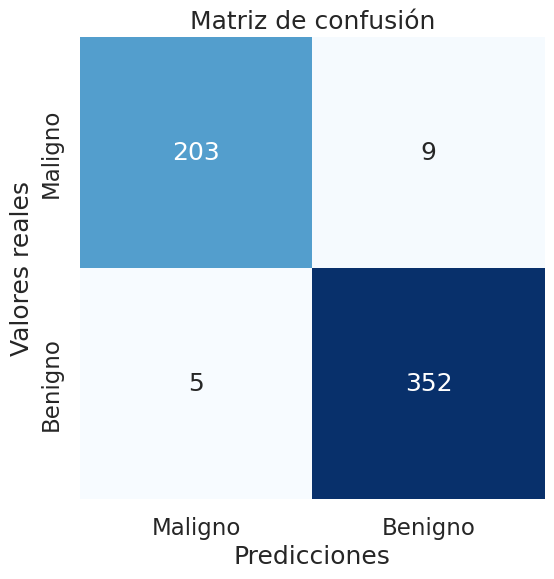

In [8]:
header('3. Analisis del problema de desbalance')
#matriz de confusión:
conf_matrix = confusion_matrix(y, y_pred_sin_sm)
print("Matriz de confusión:")
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Maligno', 'Benigno'], yticklabels=['Maligno', 'Benigno'])
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()

# 4. **Aplicación de SMOTE**
   - Aplica `SMOTE` solo al conjunto de entrenamiento dentro de cada fold.
   - Entrena nuevamente la SVM.
   - Compara métricas antes y después.


In [9]:
header('4. Aplicación de SMOTE')
pipeline2 = ImbPipeline([('smote', SMOTE (random_state=10)),('scaler', StandardScaler()),('svm', SVC(kernel='rbf'))])
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
y_pred_con_sm=cross_val_predict(pipeline2, X, y, cv=skf)
reporte_con_smote=classification_report(y, y_pred_con_sm, target_names=['Clase 0 (Maligno)', 'Clase 1 (Benigno)'])
print(f'Comparación de métricas\nReporte sin SMOTE:\n{reporte_sin_smote}\nReporte con SMOTE:\n{reporte_con_smote}')
f1_con_smote=f1_score(y, y_pred_con_sm, average=None)



................················~~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ 4. Aplicación de SMOTE ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~~················................ 


Comparación de métricas
Reporte sin SMOTE:
                   precision    recall  f1-score   support

Clase 0 (Maligno)       0.98      0.96      0.97       212
Clase 1 (Benigno)       0.98      0.99      0.98       357

         accuracy                           0.98       569
        macro avg       0.98      0.97      0.97       569
     weighted avg       0.98      0.98      0.98       569

Reporte con SMOTE:
                   precision    recall  f1-score   support

Clase 0 (Maligno)       0.97      0.97      0.97       212
Clase 1 (Benigno)       0.98      0.98      0.98       357

         accuracy                           0.98       569
        macro avg       0.97      0.97      0.97       569
     weighted avg       0.98      0.98      0.98       569



# 5. **Visualización y conclusiones**
   - Usa un gráfico de barras comparando F1 por clase antes y después.



...............···············~~~~~~~~~~~~~~~≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≋≋ 5. Visualización y conclusiones ≋≋≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈~~~~~~~~~~~~~~~···············............... 




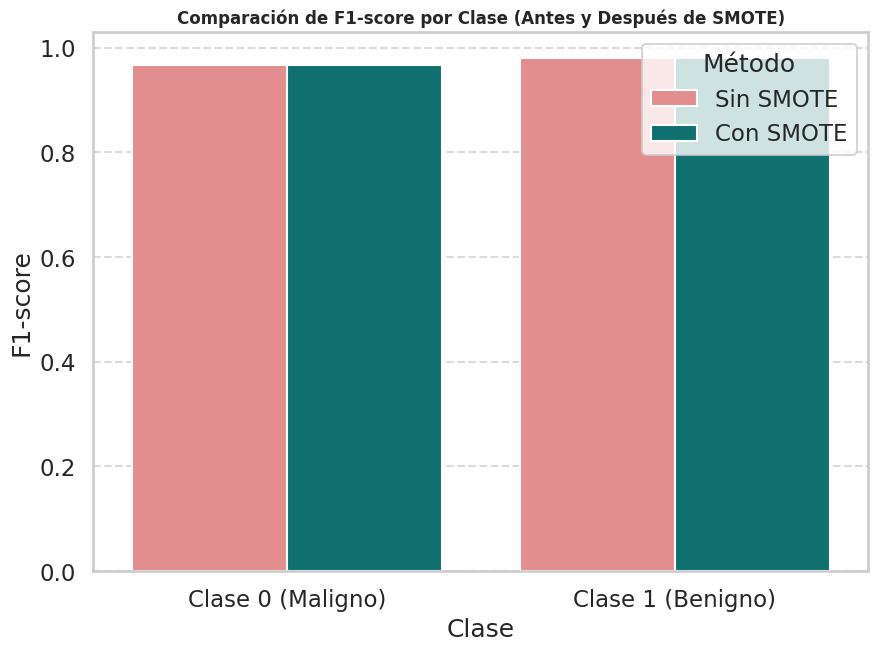

Matriz de confusión con SMOTE:


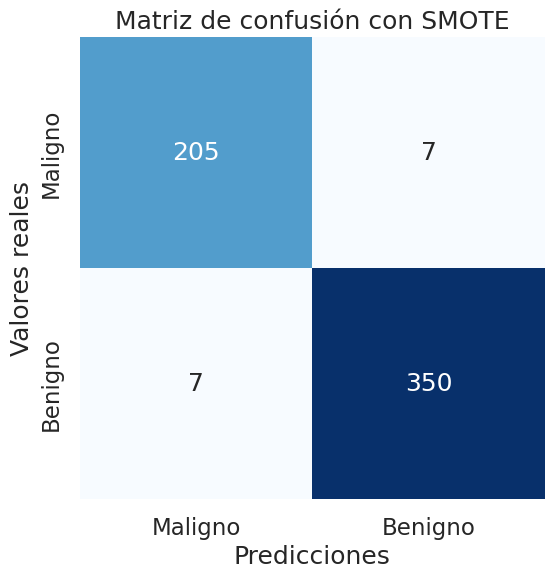

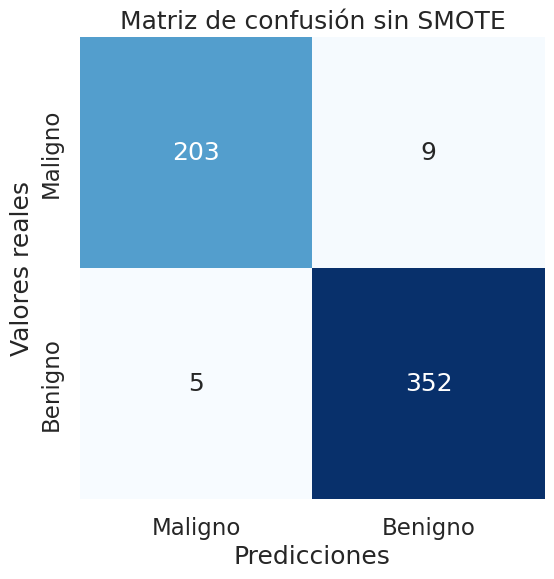

In [10]:
header('5. Visualización y conclusiones')
# Preparar datos para el gráfico de barras agrupado
clases_nombres = ['Clase 0 (Maligno)', 'Clase 1 (Benigno)']
df_f1_scores = pd.DataFrame({'Clase': clases_nombres * 2,'F1-score': np.concatenate([f1_sin_smote, f1_con_smote]),'Método': ['Sin SMOTE'] * len(clases_nombres) + ['Con SMOTE'] * len(clases_nombres)})
#se grafican con barras F1 en ambas clases antes y despues
plt.figure(figsize=(10, 7))
sns.barplot(x='Clase', y='F1-score', hue='Método', data=df_f1_scores, palette={'Sin SMOTE':'lightcoral', 'Con SMOTE':'teal'})
plt.title('Comparación de F1-score por Clase (Antes y Después de SMOTE)', size=12, weight='bold')
plt.ylabel('F1-score')
plt.xlabel('Clase')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Método')
plt.show()
#maatriz de confusión antes y despues de smote
conf_matrix_con_smote = confusion_matrix(y, y_pred_con_sm)
conf_matrix_sin_smote = confusion_matrix(y, y_pred_sin_sm)
print("Matriz de confusión con SMOTE:")
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_con_smote, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=['Maligno', 'Benigno'], yticklabels=['Maligno', 'Benigno'])
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión con SMOTE')
plt.show();separador()
#matriz de confusion sin smote
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_sin_smote, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=['Maligno', 'Benigno'], yticklabels=['Maligno', 'Benigno'])
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión sin SMOTE')
plt.show()

   - Comenta las ventajas y riesgos de aplicar SMOTE con SVM.
   - Explica cuándo conviene usar otras técnicas como `One-Sided Selection` o `ADASYN`.

*Ventajas y riesgos de SMOTE con SVM:*

**- Ventajas:**
  1. Mejora la detección de la clase minoritaria, al equilibrarlas un poco mas creando datos sinteticos en la clase minoritaria, sin modificar la mayoritaria.
  2. Evita la perdida de datos, ya que no elimina información.

**- Desventajas:**
  1. Puede generar ruido en el modelo si interpola outliers.
  2. Al generar datos sinteticos, puede solaparlos y hacer mas dificil la separación de clases para SVM.

*Explica cuándo conviene usar otras técnicas como One-Sided Selection o ADASYN.*

1. Es conveniente utilizar **One-Sided Selection** cuando se tiene una desproporción muy grande en las clases, y cuando se encuentran puntos muy pegados que se pueden generalizar, reduciendo el tamaño de la clase mayoritaria. Es un metodo de undersampling que prioriza la eliminación por detección de tomek-links (puntos pegados de la clase mayoritaria y minoritaria, deja solo la minoritaria) y los outliers de la clase mayoritaria que no aportan información útil. Solo hay que tener cuidado porque la pérdida de datos puede ser muy drástica.

2. Es conveniente utilizar **ADASYN** cuando se quiere incorportar un metodo de oversampling heurístico mas avanzado que SMOTE, generando puntos en donde mas se necesitan.